In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!apt-get -y install postgresql postgresql-contrib > /dev/null
!service postgresql start


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
 * Starting PostgreSQL 14 database server
   ...done.


In [ ]:
!pip install python-doctr[torch] matplotlib
!pip install pdf2image
!apt-get install -y poppler-utils




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━

In [1]:
##Preprocessing Layout LMV3


from transformers import LayoutLMv3Processor
from PIL import Image
import os, zipfile, shutil
import torch


zip_path = "/content/invoice data.zip"
extract_path = "/content/invoice_data"

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
with zipfile.ZipFile(zip_path, "r") as zipf:
    zipf.extractall(extract_path)


processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


label_list = ['O', 'B-INVOICE', 'I-INVOICE', 'B-DATE', 'I-DATE', 'B-AMOUNT', 'I-AMOUNT', 'B-COMPANY', 'I-COMPANY']
label2id = {label: i for i, label in enumerate(label_list)}


all_data = []
label_all_tokens = True

for fname in os.listdir(extract_path):
    if not fname.endswith(".txt"):
        continue

    img_name = fname.replace(".txt", ".jpg")
    img_path = os.path.join(extract_path, img_name)
    if not os.path.exists(img_path):
        img_name = fname.replace(".txt", ".png")
        img_path = os.path.join(extract_path, img_name)
    if not os.path.exists(img_path):
        continue

    image = Image.open(img_path).convert("RGB")
    W, H = image.size

    words, boxes, labels = [], [], []

    with open(os.path.join(extract_path, fname), "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 6:
                continue
            word, x0, y0, x1, y1, label = parts
            words.append(word)
            boxes.append([
                int(float(x0) * 1000),
                int(float(y0) * 1000),
                int(float(x1) * 1000),
                int(float(y1) * 1000)
            ])
            labels.append(label2id.get(label, 0))


    encoding = processor(
        images=image,
        text=words,
        boxes=boxes,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )


    word_ids = encoding.word_ids(batch_index=0)
    label_ids = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(labels[word_idx])
        else:
            label_ids.append(labels[word_idx] if label_all_tokens else -100)

        previous_word_idx = word_idx

    encoding["labels"] = torch.tensor(label_ids)

    all_data.append({k: v.squeeze(0) for k, v in encoding.items()})

print(f"✅ Processed {len(all_data)} samples — ready for training!")
print("📦 Example keys:", all_data[0].keys())
print("🧾 Input IDs shape:", all_data[0]['input_ids'].shape)


KeyboardInterrupt: 

In [2]:
##Training Layout LMV3

from transformers import LayoutLMv3ForTokenClassification
from transformers import LayoutLMv3Config
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm


label_list = ['O', 'B-INVOICE', 'I-INVOICE', 'B-DATE', 'I-DATE', 'B-AMOUNT', 'I-AMOUNT', 'B-COMPANY', 'I-COMPANY']
num_labels = len(label_list)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 2
num_epochs = 5
learning_rate = 5e-5


class InvoiceDataset(Dataset):
    def __init__(self, encoded_data):
        self.data = encoded_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = InvoiceDataset(all_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

config = LayoutLMv3Config.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    config=config
).to(device)


optimizer = AdamW(model.parameters(), lr=learning_rate)


model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    print(f"\n🚀 Epoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        bbox = batch["bbox"].to(device)
        labels = batch["labels"].to(device)
        pixel_values = batch["pixel_values"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels,
            return_dict=True
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch + 1} finished — Avg Loss: {avg_loss:.4f}")


output_dir = "./layoutlmv3-invoice-finetuned"
model.save_pretrained(output_dir)
print(f"\n💾 Model saved to: {output_dir}")


RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:241; latest registration was registered at /dev/null:241

In [ ]:
##Old donut + layout code working separately

from transformers import DonutProcessor, VisionEncoderDecoderModel
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image
import torch


donut_proc = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
donut_model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

layout_proc = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)
layout_model = LayoutLMv3ForTokenClassification.from_pretrained("./layoutlmv3-invoice-finetuned")

device = "cuda" if torch.cuda.is_available() else "cpu"
donut_model.to(device)
layout_model.to(device)

def extract_invoice_fields(image_path):
    image = Image.open(image_path).convert("RGB")
    results = {}

    pixel_values = donut_proc(image, return_tensors="pt").pixel_values.to(device)
    questions = {
        "Invoice Number": "What is the invoice number?",
        "Invoice Date": "What is the invoice date?",
        "Transaction Amount": "What is the total amount?",
        "Company": "What is the company name?"
    }
    for field, question in questions.items():
        prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
        decoder_input_ids = donut_proc.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
        output_ids = donut_model.generate(pixel_values, decoder_input_ids=decoder_input_ids, max_length=512)
        answer = donut_proc.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
        results[f"Donut: {field}"] = answer


    encoding = layout_proc(image, return_tensors="pt", truncation=True, padding="max_length").to(device)
    with torch.no_grad():
        outputs = layout_model(**encoding)
        pred_ids = torch.argmax(outputs.logits, dim=2)[0].cpu().tolist()

    word_ids = encoding.word_ids(batch_index=0)
    pred_labels = [layout_model.config.id2label[p] for p in pred_ids]
    input_ids = encoding["input_ids"][0]
    tokens = layout_proc.tokenizer.convert_ids_to_tokens(input_ids)


    token_buffer = {}
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        token_buffer.setdefault(word_idx, []).append(tokens[idx])

    reconstructed_words = {
        word_idx: layout_proc.tokenizer.convert_tokens_to_string(token_list).strip()
        for word_idx, token_list in token_buffer.items()
    }

    MAX_WORDS_PER_FIELD = {
        "INVOICE": 4,
        "DATE": 6,
        "AMOUNT": 6,
        "COMPANY": 8,
    }

    field_map = {k: [] for k in MAX_WORDS_PER_FIELD}
    used = set()
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx in used:
            continue
        label = pred_labels[idx]
        if label.startswith(("B-", "I-")):
            tag = label.split("-")[1]
            if tag in field_map and len(field_map[tag]) < MAX_WORDS_PER_FIELD[tag]:
                word = reconstructed_words.get(word_idx, "")
                field_map[tag].append(word)
                used.add(word_idx)

    for tag in field_map:
        results[f"LayoutLMv3: {tag}"] = " ".join(field_map[tag])

    return results


results = extract_invoice_fields("i10.jpg")

for k, v in results.items():
    print(f"{k}: {v}")


Donut: Invoice Number: What is the invoice number? avenue
Donut: Invoice Date: What is the invoice date? 03/16/2015
Donut: Transaction Amount: What is the total amount? $70.00
Donut: Company: What is the company name? websitebackup
LayoutLMv3: INVOICE: 2375 85016 HOZ-888 8:00AM
LayoutLMv3: DATE: 03/16/2015 Monday - Thursday Friday 4:00PM
LayoutLMv3: AMOUNT: $70.00 - Included $0.00 Included $0.00
LayoutLMv3: COMPANY: Gg WebsiteBackup. DEPENDABLE BACKUP PROTECTION WEBSITEBACKUP COMPANY 0900


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1731: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
##Old donut + layout code working together

from transformers import DonutProcessor, VisionEncoderDecoderModel
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image
import torch

# Load models and processors
donut_proc = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
donut_model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

layout_proc = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)
layout_model = LayoutLMv3ForTokenClassification.from_pretrained("./layoutlmv3-invoice-finetuned")

device = "cuda" if torch.cuda.is_available() else "cpu"
donut_model.to(device)
layout_model.to(device)

def extract_invoice_fields(image_path):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    results = {}

    # 🔹 Step 1: Use LayoutLMv3 to find bounding boxes for each field
    encoding = layout_proc(image, return_tensors="pt", truncation=True, padding="max_length").to(device)
    with torch.no_grad():
        outputs = layout_model(**encoding)
        pred_ids = torch.argmax(outputs.logits, dim=2)[0].cpu().tolist()

    word_ids = encoding.word_ids(batch_index=0)
    pred_labels = [layout_model.config.id2label[p] for p in pred_ids]
    bbox_list = encoding.bbox[0].cpu().tolist()

    field_coords = {"INVOICE": [], "DATE": [], "AMOUNT": [], "COMPANY": []}
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        label = pred_labels[idx]
        if label.startswith(("B-", "I-")):
            tag = label.split("-")[1]
            if tag in field_coords:
                field_coords[tag].append(bbox_list[idx])

    def get_crop_box(bboxes, pad=5):
        if not bboxes:
            return None
        x0 = min(b[0] for b in bboxes)
        y0 = min(b[1] for b in bboxes)
        x1 = max(b[2] for b in bboxes)
        y1 = max(b[3] for b in bboxes)

        left = max(0, int((x0 - pad) / 1000 * width))
        top = max(0, int((y0 - pad) / 1000 * height))
        right = min(width, int((x1 + pad) / 1000 * width))
        bottom = min(height, int((y1 + pad) / 1000 * height))
        return (left, top, right, bottom)

    # 🔹 Step 2: Use Donut to extract answer from cropped field regions
    questions = {
        "INVOICE": "What is the invoice number?",
        "DATE": "What is the invoice date?",
        "AMOUNT": "What is the total amount?",
        "COMPANY": "What is the company name?"
    }

    for tag, question in questions.items():
        crop_box = get_crop_box(field_coords[tag])
        cropped = image.crop(crop_box) if crop_box else image  # fallback to full image

        pixel_values = donut_proc(cropped, return_tensors="pt").pixel_values.to(device)
        prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
        decoder_input_ids = donut_proc.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
        output_ids = donut_model.generate(pixel_values, decoder_input_ids=decoder_input_ids, max_length=512)
        answer = donut_proc.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
        results[question] = answer

    return results

results = extract_invoice_fields("i2.jpg")

# Output results
for k, v in results.items():
    print(f"{k}: {v}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1731: FutureWarning: The `device` argument is deprecated and will be removed in v5 of T

What is the invoice number?: What is the invoice number? $375.00
What is the invoice date?: What is the invoice date? $50/hr
What is the total amount?: What is the total amount? $875.00
What is the company name?: What is the company name? willed to


In [ ]:
##DocTR testing to extract company name with AWS

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import matplotlib.pyplot as plt
import re
import requests

model = ocr_predictor(pretrained=True)


doc = DocumentFile.from_images("i2.jpg")
result = model(doc)
page = result.export()["pages"][0]


BUSINESS_SUFFIXES = {"ltd", "inc", "llc", "company", "group", "corp", "co", "technologies", "consulting", "associates"}
STOPWORDS = {"invoice", "paid", "total", "payment", "reference", "order", "date", "vat", "billing", "delivery", "address", "id", "to", "number", "amount"}

def is_clean_brand_candidate(text):
    text_lower = text.lower()
    if any(sw in text_lower for sw in STOPWORDS):
        return False
    if len(text.split()) > 5 or len(text) < 2:
        return False
    if re.search(r"\d{4,}", text_lower):
        return False
    return True

def has_business_keywords(text):
    return any(suffix in text.lower() for suffix in BUSINESS_SUFFIXES)

def is_context_label(text):
    labels = ["bill to", "pay to", "ship to", "invoice to", "customer", "account", "remit to"]
    return any(lbl in text.lower() for lbl in labels)


top_lines = []
label_zone_lines = set()

print("\n🔍 Top Layout Lines (Top 25% of page):")
for block in page["blocks"]:
    for line in block["lines"]:
        ymin = line["geometry"][0][1]
        ymax = line["geometry"][1][1]
        vertical_center = (ymin + ymax) / 2

        text = " ".join(word["value"] for word in line["words"]).strip()
        if not text:
            continue

        if vertical_center < 0.25:
            top_lines.append((vertical_center, text))
            print(f"🟩 {text}")

        if is_context_label(text):
            label_zone_lines.add(text)

top_lines = sorted(top_lines, key=lambda x: x[0])
top_texts = [text for _, text in top_lines]


brand_guess = ""
company_guess = ""

for line in top_texts:
    if is_clean_brand_candidate(line) and not has_business_keywords(line):
        brand_guess = line
        break

if not brand_guess:
    for line in top_texts:
        if has_business_keywords(line) and line not in label_zone_lines:
            company_guess = line
            break

best_guess = brand_guess or company_guess or (top_texts[0] if top_texts else "Not found")

candidates = []
for line in top_texts:
    if is_clean_brand_candidate(line) or has_business_keywords(line):
        candidates.append(line)

print("\n🧾 Candidate Company Lines:")
for c in candidates:
    print("-", c)

def get_best_company_name_from_lambda(candidates, lambda_url):
    payload = {
        "mode": "extract_company_name",
        "candidates": candidates
    }

    try:
        response = requests.post(lambda_url, json=payload)
        response.raise_for_status()
        data = response.json()
        return data.get("best_match"), data.get("organization_entities", [])
    except Exception as e:
        print(f"❌ Lambda call failed: {e}")
        return None, []


lambda_url = "https://dcd4cvmjb2.execute-api.us-east-1.amazonaws.com/prod/company-name"
best_match, orgs = get_best_company_name_from_lambda(candidates, lambda_url)

final_company_name = best_match or best_guess

print(f"\n✅ Final Company Name (Lambda + Fallback): {final_company_name}")
print(f"🔍 All ORGs Found by AWS Comprehend: {orgs}")



🔍 Top Layout Lines (Top 25% of page):
🟩 NVOICE
🟩 #1024
🟩 BILLED TO:
🟩 Really Great Company
🟩 PAY TO:
🟩 Avery Davis

🧾 Candidate Company Lines:
- NVOICE
- Really Great Company
- Avery Davis

✅ Final Company Name (Lambda + Fallback): NVOICE
🔍 All ORGs Found by AWS Comprehend: ['NVOICE']


In [ ]:
## Old version of final program

from transformers import DonutProcessor, VisionEncoderDecoderModel
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image
import torch
import base64
import requests
import json
import re
import pytesseract
from io import BytesIO
import sqlite3
import difflib
from IPython.display import clear_output

donut_proc = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
donut_model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
donut_model.to("cuda" if torch.cuda.is_available() else "cpu")
device = donut_model.device

doctr_model = ocr_predictor(pretrained=True)

GENERIC_INVALIDS = {"invoice", "receipt", "bill", "document", ""}
EDGE_INVALIDS = {"invoice", "receipt", "document", "sold", "sold by", "from", "invoice to", "billed by"}
BUSINESS_SUFFIXES = {"ltd", "inc", "llc", "company", "group", "corp", "co", "technologies", "consulting", "associates"}
STOPWORDS = {"invoice", "paid", "total", "payment", "reference", "order", "date", "vat", "billing", "delivery", "address", "id", "to", "number", "amount"}
UPLOAD_LAMBDA_URL = "https://dcd4cvmjb2.execute-api.us-east-1.amazonaws.com/prod/upload"
COMPANY_NAME_LAMBDA_URL = "https://dcd4cvmjb2.execute-api.us-east-1.amazonaws.com/prod/company-name"

def contains_digit(s): return bool(re.search(r'\d', s))
def is_valid_invoice_number(text): return bool(text) and contains_digit(text) and text.lower().strip() not in GENERIC_INVALIDS
def has_invalid_edges(text):
    text = text.strip().lower()
    tokens = text.split()
    return tokens and (tokens[0] in EDGE_INVALIDS or tokens[-1] in EDGE_INVALIDS)

def extract_invoice_number_from_text(text):
    patterns = [
        r"(invoice number)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(invoice no)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(invoice #)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"#\s*([A-Za-z0-9\-\/]+)"
    ]
    for pattern in patterns:
        match = re.search(pattern, text, flags=re.IGNORECASE)
        if match:
            candidate = match.group(2).strip()
            if is_valid_invoice_number(candidate):
                return candidate
    return ""

def extract_with_donut(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = donut_proc(image, return_tensors="pt").pixel_values.to(device)
    questions = {
        "invoice_number": "What is the invoice number?",
        "invoice_date": "What is the invoice date?",
        "transaction_amount": "What is the invoice total or final total payable amount or grand total?"
    }
    results = {}
    for field, question in questions.items():
        prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
        decoder_input_ids = donut_proc.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
        output_ids = donut_model.generate(pixel_values, decoder_input_ids=decoder_input_ids, max_length=512)
        answer = donut_proc.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
        results[field] = answer
    return results

def extract_from_lambda(image_path, filename, ignored_names=[]):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode("utf-8")
    payload = {"filename": filename, "file": encoded, "reject": ignored_names}
    try:
        res = requests.post(UPLOAD_LAMBDA_URL, json=payload)
        fields = res.json().get("fields", {})
        return fields.get("company_name", ""), fields.get("invoice_number", "")
    except Exception as e:
        print(f"Lambda call failed: {e}")
        return "", ""

def extract_company_name_with_doctr(image_path, rejected_name=""):
    doc = DocumentFile.from_images(image_path)
    result = doctr_model(doc)
    page = result.export()["pages"][0]
    top_lines = []

    for block in page["blocks"]:
        for line in block["lines"]:
            ymin, ymax = line["geometry"][0][1], line["geometry"][1][1]
            vertical_center = (ymin + ymax) / 2
            text = " ".join(word["value"] for word in line["words"]).strip()
            if text and vertical_center < 0.25:
                top_lines.append((vertical_center, text))

    top_lines = sorted(top_lines, key=lambda x: x[0])
    top_texts = [text for _, text in top_lines if text.lower().strip() != rejected_name.lower().strip()]
    candidates = [t for t in top_texts if len(t.split()) <= 5 and not any(sw in t.lower() for sw in STOPWORDS)]

    if not candidates:
        return rejected_name

    try:
        payload = {"mode": "extract_company_name", "candidates": candidates}
        response = requests.post(COMPANY_NAME_LAMBDA_URL, json=payload)
        data = response.json()
        return data.get("best_match") or candidates[0]
    except:
        return candidates[0]

def extract_invoice_fields_combined(image_path):
    filename = image_path.split("/")[-1]
    donut_fields = extract_with_donut(image_path)
    donut_invoice_number = donut_fields.get("invoice_number", "")
    invoice_number = ""
    company_name = ""

    print("🔵 Extracting fields using Donut...")
    print("🔴 Extracting fields using AWS...")
    if is_valid_invoice_number(donut_invoice_number):
        invoice_number = donut_invoice_number
        print(f"✅ Valid Donut Invoice Number: {invoice_number}")
    else:
        print("⚠️ Donut invoice number invalid. Trying AWS...")
        company_name, lambda_invoice_number = extract_from_lambda(image_path, filename)
        if is_valid_invoice_number(lambda_invoice_number):
            invoice_number = lambda_invoice_number
            print(f"✅ Using AWS invoice number: {invoice_number}")
        else:
            print("❌ AWS invoice number also invalid. Falling back to OCR regex...")
            text = pytesseract.image_to_string(Image.open(image_path))
            invoice_number = extract_invoice_number_from_text(text)
            print(f"🔁 Fallback Invoice Number: {invoice_number}")

    if not company_name:
        company_name, _ = extract_from_lambda(image_path, filename)

    if has_invalid_edges(company_name):
        print(f"⚠️ Invalid company name detected: {company_name}")
        print("🟢 Extracting fields using DocTR...")
        company_name = extract_company_name_with_doctr(image_path, rejected_name=company_name)

    return {
        "Invoice Number": invoice_number,
        "Invoice Date": donut_fields.get("invoice_date"),
        "Transaction Amount": donut_fields.get("transaction_amount"),
        "Company Name": company_name
    }

def compute_similarity(a, b):
    return difflib.SequenceMatcher(None, str(a).lower().strip(), str(b).lower().strip()).ratio()

def score_match(predicted, candidate):
    total = sum(compute_similarity(predicted[k], candidate.get(k, "")) for k in predicted if predicted[k])
    count = sum(1 for k in predicted if predicted[k])
    return total / count if count else 0

def fetch_all_records():
    conn = sqlite3.connect("invoices.db")
    cur = conn.cursor()
    cur.execute("SELECT invoice_number, invoice_date, company_name, total_amount FROM invoices")
    rows = cur.fetchall()
    conn.close()
    return [{"Invoice Number": r[0], "Invoice Date": r[1], "Company Name": r[2], "Transaction Amount": r[3]} for r in rows]

def print_boxed_record(record):
    print(f"\n╔{'═'*50}╗")
    for k, v in record.items():
        print(f"║ {k:<18}: {v}")
    print(f"╚{'═'*50}╝")


image_path = "i4.png"
fields = extract_invoice_fields_combined(image_path)

print("\n✅ Final Extracted Fields (Console Output):")
for k, v in fields.items():
    print(f"{k}: {v}")

records = fetch_all_records()
scored = [(r, score_match(fields, r)) for r in records]
scored.sort(key=lambda x: x[1], reverse=True)

if input("\n🔍 View best DB match? (yes/no): ").strip().lower() == "yes" and scored:
    best, _ = scored[0]
    print_boxed_record(best)

    view_others = input("\n📋 View all other matches? (yes/no): ").strip().lower()
    if view_others == "yes":
        for r, _ in scored[1:]:
            print_boxed_record(r)
    else:
        print("\n✅ Done. No other matches shown.")

else:
    print("\n✅ Program ended without showing database matches.")



🔵 Extracting fields using Donut...
🔴 Extracting fields using AWS...
⚠️ Donut invoice number invalid. Trying AWS...
✅ Using AWS invoice number: GALT-009

✅ Final Extracted Fields (Console Output):
Invoice Number: GALT-009
Invoice Date: What is the invoice date? aug 31, 2013
Transaction Amount: What is the invoice total or final total payable amount or grand total? $11,812.50
Company Name: Fountainhead A+E

🔍 View best DB match? (yes/no): no

✅ Program ended without showing database matches.


In [ ]:
## Start PostGreSQL server
!sudo -u postgres psql -c "CREATE USER colabuser WITH PASSWORD 'colabpass';"
!sudo -u postgres psql -c "CREATE DATABASE colabdb OWNER colabuser;"


CREATE ROLE
CREATE DATABASE


In [ ]:
##PostGreSQL data setup

import psycopg2


conn = psycopg2.connect(
    dbname="colabdb",
    user="colabuser",
    password="colabpass",
    host="localhost"
)

cur = conn.cursor()


cur.execute('''
    CREATE TABLE IF NOT EXISTS invoices (
        id SERIAL PRIMARY KEY,
        invoice_number TEXT,
        invoice_date TEXT,
        company_name TEXT,
        total_amount TEXT
    );
''')

dummy_data = [
    ("INV-001", "2023-09-12", "Acme Corporation", "$875.00"),
    ("15", "05-Jan-04", "The Office Solutions Organisation", "8.93"),
    ("", "03/16/2015", "WebsiteBackup Company", "$70.00"),
    ("INV-004", "2023-09-11", "Delta Corp", "$875.00"),
    ("INV-005", "2023-09-09", "Omega Inc", "$1150.00"),
]

cur.executemany(
    "INSERT INTO invoices (invoice_number, invoice_date, company_name, total_amount) VALUES (%s, %s, %s, %s);",
    dummy_data
)

conn.commit()
cur.close()
conn.close()

print("✅ PostgreSQL invoice database initialized.")


✅ PostgreSQL invoice database initialized.


In [ ]:
##Final program

from transformers import DonutProcessor, VisionEncoderDecoderModel
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image
import numpy as np
import torch
import base64
import requests
import json
import re
import pytesseract
from io import BytesIO
import psycopg2
import difflib
from IPython.display import clear_output
import os
import csv
from pdf2image import convert_from_path
from PIL import ImageEnhance, ImageOps, ImageFilter


#### Donut and DocTR model setup
donut_proc = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
donut_model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
donut_model.to("cuda" if torch.cuda.is_available() else "cpu")
device = donut_model.device

doctr_model = ocr_predictor(pretrained=True)

#### Constants
GENERIC_INVALIDS = {"invoice", "receipt", "bill", "document", ""}
EDGE_INVALIDS = {"invoice", "receipt", "document", "sold", "sold by", "from", "invoice to", "billed by"}
BUSINESS_SUFFIXES = {"ltd", "inc", "llc", "company", "group", "corp", "co", "technologies", "consulting", "associates"}
STOPWORDS = {"invoice", "paid", "total", "payment", "reference", "order", "date", "vat", "billing", "delivery", "address", "id", "to", "number", "amount"}
UPLOAD_LAMBDA_URL = "https://dcd4cvmjb2.execute-api.us-east-1.amazonaws.com/prod/upload"
COMPANY_NAME_LAMBDA_URL = "https://dcd4cvmjb2.execute-api.us-east-1.amazonaws.com/prod/company-name"

def contains_digit(s): return bool(re.search(r'\d', s))
def is_valid_invoice_number(text): return bool(text) and contains_digit(text) and text.lower().strip() not in GENERIC_INVALIDS
def has_invalid_edges(text):
    text = text.strip().lower()
    tokens = text.split()
    return tokens and (tokens[0] in EDGE_INVALIDS or tokens[-1] in EDGE_INVALIDS)

def extract_invoice_number_from_text(text):
    patterns = [
        r"(invoice number)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(invoice no)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(invoice #)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(inv number)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(inv no)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(inv #)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(invoice num)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(inv num)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(document number)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(document #)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(document no)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(doc number)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(doc no)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(doc #)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(document num)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"(doc num)[:\s\-]*([A-Za-z0-9\-\/]+)",
        r"#\s*([A-Za-z0-9\-\/]+)"
    ]
    for pattern in patterns:
        match = re.search(pattern, text, flags=re.IGNORECASE)
        if match:
            candidate = match.group(2).strip()
            if is_valid_invoice_number(candidate):
                return candidate
    return ""

def extract_with_donut(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = donut_proc(image, return_tensors="pt").pixel_values.to(device)
    questions = {
        "invoice_number": "What is the invoice number?",
        "invoice_date": "What is the invoice date?",
        "transaction_amount": "What is the invoice total or final total payable amount or grand total?"
    }
    results = {}
    for field, question in questions.items():
        prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
        decoder_input_ids = donut_proc.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
        output_ids = donut_model.generate(pixel_values, decoder_input_ids=decoder_input_ids, max_length=512)
        answer = donut_proc.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
        if answer.lower().startswith(question.lower()):
            answer = answer[len(question):].strip(": \n")
        results[field] = answer
    return results

def extract_from_lambda(image_path, filename, ignored_names=[]):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode("utf-8")
    payload = {"filename": filename, "file": encoded, "reject": ignored_names}
    try:
        res = requests.post(UPLOAD_LAMBDA_URL, json=payload)
        fields = res.json().get("fields", {})
        return fields.get("company_name", ""), fields.get("invoice_number", "")
    except Exception as e:
        print(f"Lambda call failed: {e}")
        return "", ""

import numpy as np

def extract_company_name_with_doctr(image_input, rejected_name=""):
    if isinstance(image_input, Image.Image):
        if image_input.mode != "RGB":
            image_input = image_input.convert("RGB")
        image_input = np.array(image_input).astype(np.uint8)

    if isinstance(image_input, np.ndarray):
        result = doctr_model([image_input])
    elif isinstance(image_input, str):
        doc = DocumentFile.from_images([image_input])
        result = doctr_model(doc)
    else:
        raise TypeError(f"Unsupported image input type: {type(image_input)}")

    page = result.export()["pages"][0]
    top_lines = []

    for block in page["blocks"]:
        for line in block["lines"]:
            ymin, ymax = line["geometry"][0][1], line["geometry"][1][1]
            vertical_center = (ymin + ymax) / 2
            text = " ".join(word["value"] for word in line["words"]).strip()
            if text and vertical_center < 0.25:
                top_lines.append((vertical_center, text))

    top_lines = sorted(top_lines, key=lambda x: x[0])
    top_texts = [text for _, text in top_lines if text.lower().strip() != rejected_name.lower().strip()]
    candidates = [t for t in top_texts if len(t.split()) <= 5 and not any(sw in t.lower() for sw in STOPWORDS)]

    if not candidates:
        return rejected_name

    try:
        payload = {"mode": "extract_company_name", "candidates": candidates}
        response = requests.post(COMPANY_NAME_LAMBDA_URL, json=payload)
        data = response.json()
        return data.get("best_match") or candidates[0]
    except:
        return candidates[0]



def extract_invoice_fields_combined(file_path):
    filename = file_path.split("/")[-1]
    sources = {}

    if file_path.lower().endswith(".pdf"):
        print("📄 Detected PDF. Extracting first page as image...")
        pil_images = convert_from_path(file_path, dpi=300)
        if not pil_images:
            raise ValueError("PDF has no pages.")
        image = pil_images[0].convert("RGB")
    else:
        image = Image.open(file_path).convert("RGB")

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)
    #image = image.filter(ImageFilter.SHARPEN)              --- change according to desired sharpness
    image = image.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

    image = ImageOps.grayscale(image).convert("RGB")



    #### Run Donut
    pixel_values = donut_proc(image, return_tensors="pt").pixel_values.to(device)
    questions = {
        "invoice_number": "What is the invoice number?",
        "invoice_date": "What is the invoice date?",
        "transaction_amount": "What is the invoice total or final total payable amount or grand total?"
    }
    donut_fields = {}
    for field, question in questions.items():
        prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
        decoder_input_ids = donut_proc.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)
        output_ids = donut_model.generate(pixel_values, decoder_input_ids=decoder_input_ids, max_length=512)
        answer = donut_proc.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
        if answer.lower().startswith(question.lower()):
            answer = answer[len(question):].strip(": \n")
        donut_fields[field] = answer

    donut_invoice_number = donut_fields.get("invoice_number", "")
    invoice_number = ""
    company_name = ""

    print("🔵 Extracting fields using Donut...")
    print("🔴 Extracting fields using AWS...")

    #### Invoice Number
    if is_valid_invoice_number(donut_invoice_number):
        invoice_number = donut_invoice_number
        sources["Invoice Number"] = "Donut"
        print(f"✅ Valid Donut Invoice Number: {invoice_number}")
    else:
        print("⚠️ Donut invoice number invalid. Trying AWS...")
        company_name, lambda_invoice_number = extract_from_lambda(file_path, filename)
        if is_valid_invoice_number(lambda_invoice_number):
            invoice_number = lambda_invoice_number
            sources["Invoice Number"] = "AWS"
            print(f"✅ Using AWS invoice number: {invoice_number}")
        else:
            print("❌ AWS invoice number also invalid. Falling back to OCR regex...")
            fallback_image = image if file_path.lower().endswith(".pdf") else Image.open(file_path)
            text = pytesseract.image_to_string(fallback_image)
            invoice_number = extract_invoice_number_from_text(text)
            sources["Invoice Number"] = "Tesseract"
            print(f"🔁 Fallback Invoice Number: {invoice_number}")

    #### Company Name
    if not company_name:
        company_name, _ = extract_from_lambda(file_path, filename)
        sources["Company Name"] = "AWS"

    if has_invalid_edges(company_name):
        print(f"⚠️ Invalid company name detected: {company_name}")
        print("🟢 Extracting fields using DocTR...")
        doctr_image_path = image if file_path.lower().endswith(".pdf") else file_path
        company_name = extract_company_name_with_doctr(doctr_image_path, rejected_name=company_name)
        sources["Company Name"] = "DocTR"

    #### Donut provides other fields
    sources["Invoice Date"] = "Donut"
    sources["Transaction Amount"] = "Donut"

    return {
        "Invoice Number": invoice_number,
        "Invoice Date": donut_fields.get("invoice_date"),
        "Transaction Amount": donut_fields.get("transaction_amount"),
        "Company Name": company_name
    }, sources


def compute_similarity(a, b):
    return difflib.SequenceMatcher(None, str(a).lower().strip(), str(b).lower().strip()).ratio()

def score_match(predicted, candidate):
    total = sum(compute_similarity(predicted[k], candidate.get(k, "")) for k in predicted if predicted[k])
    count = sum(1 for k in predicted if predicted[k])
    return total / count if count else 0

def fetch_all_records():
    conn = psycopg2.connect(
        dbname="colabdb",
        user="colabuser",
        password="colabpass",
        host="localhost"
    )
    cur = conn.cursor()
    cur.execute("SELECT invoice_number, invoice_date, company_name, total_amount FROM invoices;")
    rows = cur.fetchall()
    conn.close()
    return [{"Invoice Number": r[0], "Invoice Date": r[1], "Company Name": r[2], "Transaction Amount": r[3]} for r in rows]

def print_boxed_record(record):
    print(f"\n╔{'═'*50}╗")
    for k, v in record.items():
        print(f"║ {k:<18}: {v}")
    print(f"╚{'═'*50}╝")

def log_to_csv(fields, sources, image_name, csv_path="extracted_log.csv"):
    file_exists = os.path.isfile(csv_path)
    with open(csv_path, mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow([
                "Image Name",
                "Invoice Number", "Invoice Number Source",
                "Invoice Date", "Invoice Date Source",
                "Transaction Amount", "Transaction Amount Source",
                "Company Name", "Company Name Source"
            ])
        writer.writerow([
            image_name,
            fields.get("Invoice Number"), sources.get("Invoice Number"),
            fields.get("Invoice Date"), sources.get("Invoice Date"),
            fields.get("Transaction Amount"), sources.get("Transaction Amount"),
            fields.get("Company Name"), sources.get("Company Name")
        ])

#### Run on file (change the invoice you want to test in below line)
image_path = "i10.jpg"
fields, sources = extract_invoice_fields_combined(image_path)

log_to_csv(fields, sources, image_path)

print("\n✅ Final Extracted Fields (Console Output):")
for k, v in fields.items():
    print(f"{k}: {v} (via {sources.get(k, 'Unknown')})")

records = fetch_all_records()
scored = [(r, score_match(fields, r)) for r in records]
scored.sort(key=lambda x: x[1], reverse=True)

if input("\n🔍 View best DB match? (yes/no): ").strip().lower() == "yes" and scored:
    best, _ = scored[0]
    print_boxed_record(best)

    view_others = input("\n📋 View all other matches? (yes/no): ").strip().lower()
    if view_others == "yes":
        for r, _ in scored[1:]:
            print_boxed_record(r)
    else:
        print("\n✅ Done. No other matches shown.")

else:
    print("\n✅ Program ended without showing database matches.")


🔵 Extracting fields using Donut...
🔴 Extracting fields using AWS...
✅ Valid Donut Invoice Number: 003

✅ Final Extracted Fields (Console Output):
Invoice Number: 003 (via Donut)
Invoice Date: 03/16/2015 (via Donut)
Transaction Amount: $70.00 (via Donut)
Company Name: WEBSITEBACKUP COMPANY (via AWS)

🔍 View best DB match? (yes/no): yes

╔══════════════════════════════════════════════════╗
║ Invoice Number    : 
║ Invoice Date      : 03/16/2015
║ Company Name      : WebsiteBackup Company
║ Transaction Amount: $70.00
╚══════════════════════════════════════════════════╝

📋 View all other matches? (yes/no): no

✅ Done. No other matches shown.


In [ ]:
##Python Script for distortion of invoices

from PIL import Image, ImageDraw, ImageEnhance
import numpy as np
import random

def add_black_dot_noise(img, dot_count=150, dot_size=1):
    draw = ImageDraw.Draw(img)
    w, h = img.size
    for _ in range(dot_count):
        x = random.randint(0, w - dot_size)
        y = random.randint(0, h - dot_size)
        draw.rectangle([(x, y), (x + dot_size, y + dot_size)], fill="black")
    return img

def slight_pixelate(img, scale_factor=0.97):
    w, h = img.size
    new_w = max(1, int(w * scale_factor))
    new_h = max(1, int(h * scale_factor))
    small = img.resize((new_w, new_h), resample=Image.BILINEAR)
    return small.resize((w, h), resample=Image.BILINEAR)

def add_gaussian_noise(img, std=8):
    np_img = np.array(img).astype(np.int16)
    noise = np.random.normal(0, std, np_img.shape).astype(np.int16)
    noisy = np.clip(np_img + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)

def apply_yellow_tint(img, intensity=0.2):
    yellow_overlay = Image.new("RGB", img.size, (255, 255, 180))
    return Image.blend(img, yellow_overlay, intensity)

def adjust_brightness_contrast(img, brightness=1.08, contrast=1.1):
    img = ImageEnhance.Brightness(img).enhance(brightness)
    img = ImageEnhance.Contrast(img).enhance(contrast)
    return img

def add_scan_lines(img, line_count=6):
    draw = ImageDraw.Draw(img)
    w, h = img.size
    for _ in range(line_count):
        y = random.randint(0, h)
        shade = random.randint(100, 160)
        draw.line([(0, y), (w, y)], fill=(shade, shade, shade), width=1)
    return img

def add_vertical_streaks(img, streak_count=2):
    draw = ImageDraw.Draw(img)
    w, h = img.size
    for _ in range(streak_count):
        x = random.randint(0, w)
        shade = random.randint(200, 230)
        for y in range(h):
            if random.random() < 0.25:
                draw.point((x, y), fill=(shade, shade, shade))
    return img

def add_ink_smudges(img, smudge_count=3):
    draw = ImageDraw.Draw(img)
    w, h = img.size
    for _ in range(smudge_count):
        x = random.randint(0, w - 50)
        y = random.randint(0, h - 20)
        blob_w = random.randint(20, 50)
        blob_h = random.randint(5, 15)
        gray = random.randint(60, 100)
        draw.ellipse([(x, y), (x + blob_w, y + blob_h)], fill=(gray, gray, gray))
    return img

def add_scanner_border_shadow(img, thickness=10):
    w, h = img.size
    shadow = Image.new("RGB", img.size, (0, 0, 0))
    mask = Image.new("L", img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle([thickness, thickness, w - thickness, h - thickness], fill=255)
    return Image.composite(img, shadow, mask)

def process_image(input_path, output_path):
    img = Image.open(input_path).convert("RGB")

    img = add_black_dot_noise(img)
    img = slight_pixelate(img)
    img = add_gaussian_noise(img)
    img = apply_yellow_tint(img)
    img = adjust_brightness_contrast(img)

    img = add_scan_lines(img)
    img = add_vertical_streaks(img)
    img = add_ink_smudges(img)
    img = add_scanner_border_shadow(img)

    img.save(output_path, format="PNG")
    print(f"✅ Saved subtle scanned-style image to: {output_path}")

if __name__ == "__main__":
    input_img_path = "i8.jpg"
    output_img_path = "d8.png"
    process_image(input_img_path, output_img_path)


✅ Saved subtle scanned-style image to: d8.png


Saving i1.pdf to i1 (1).pdf
📁 Uploaded file: i1 (1).pdf
✅ Converted image saved as: converted_i1 (1).jpg


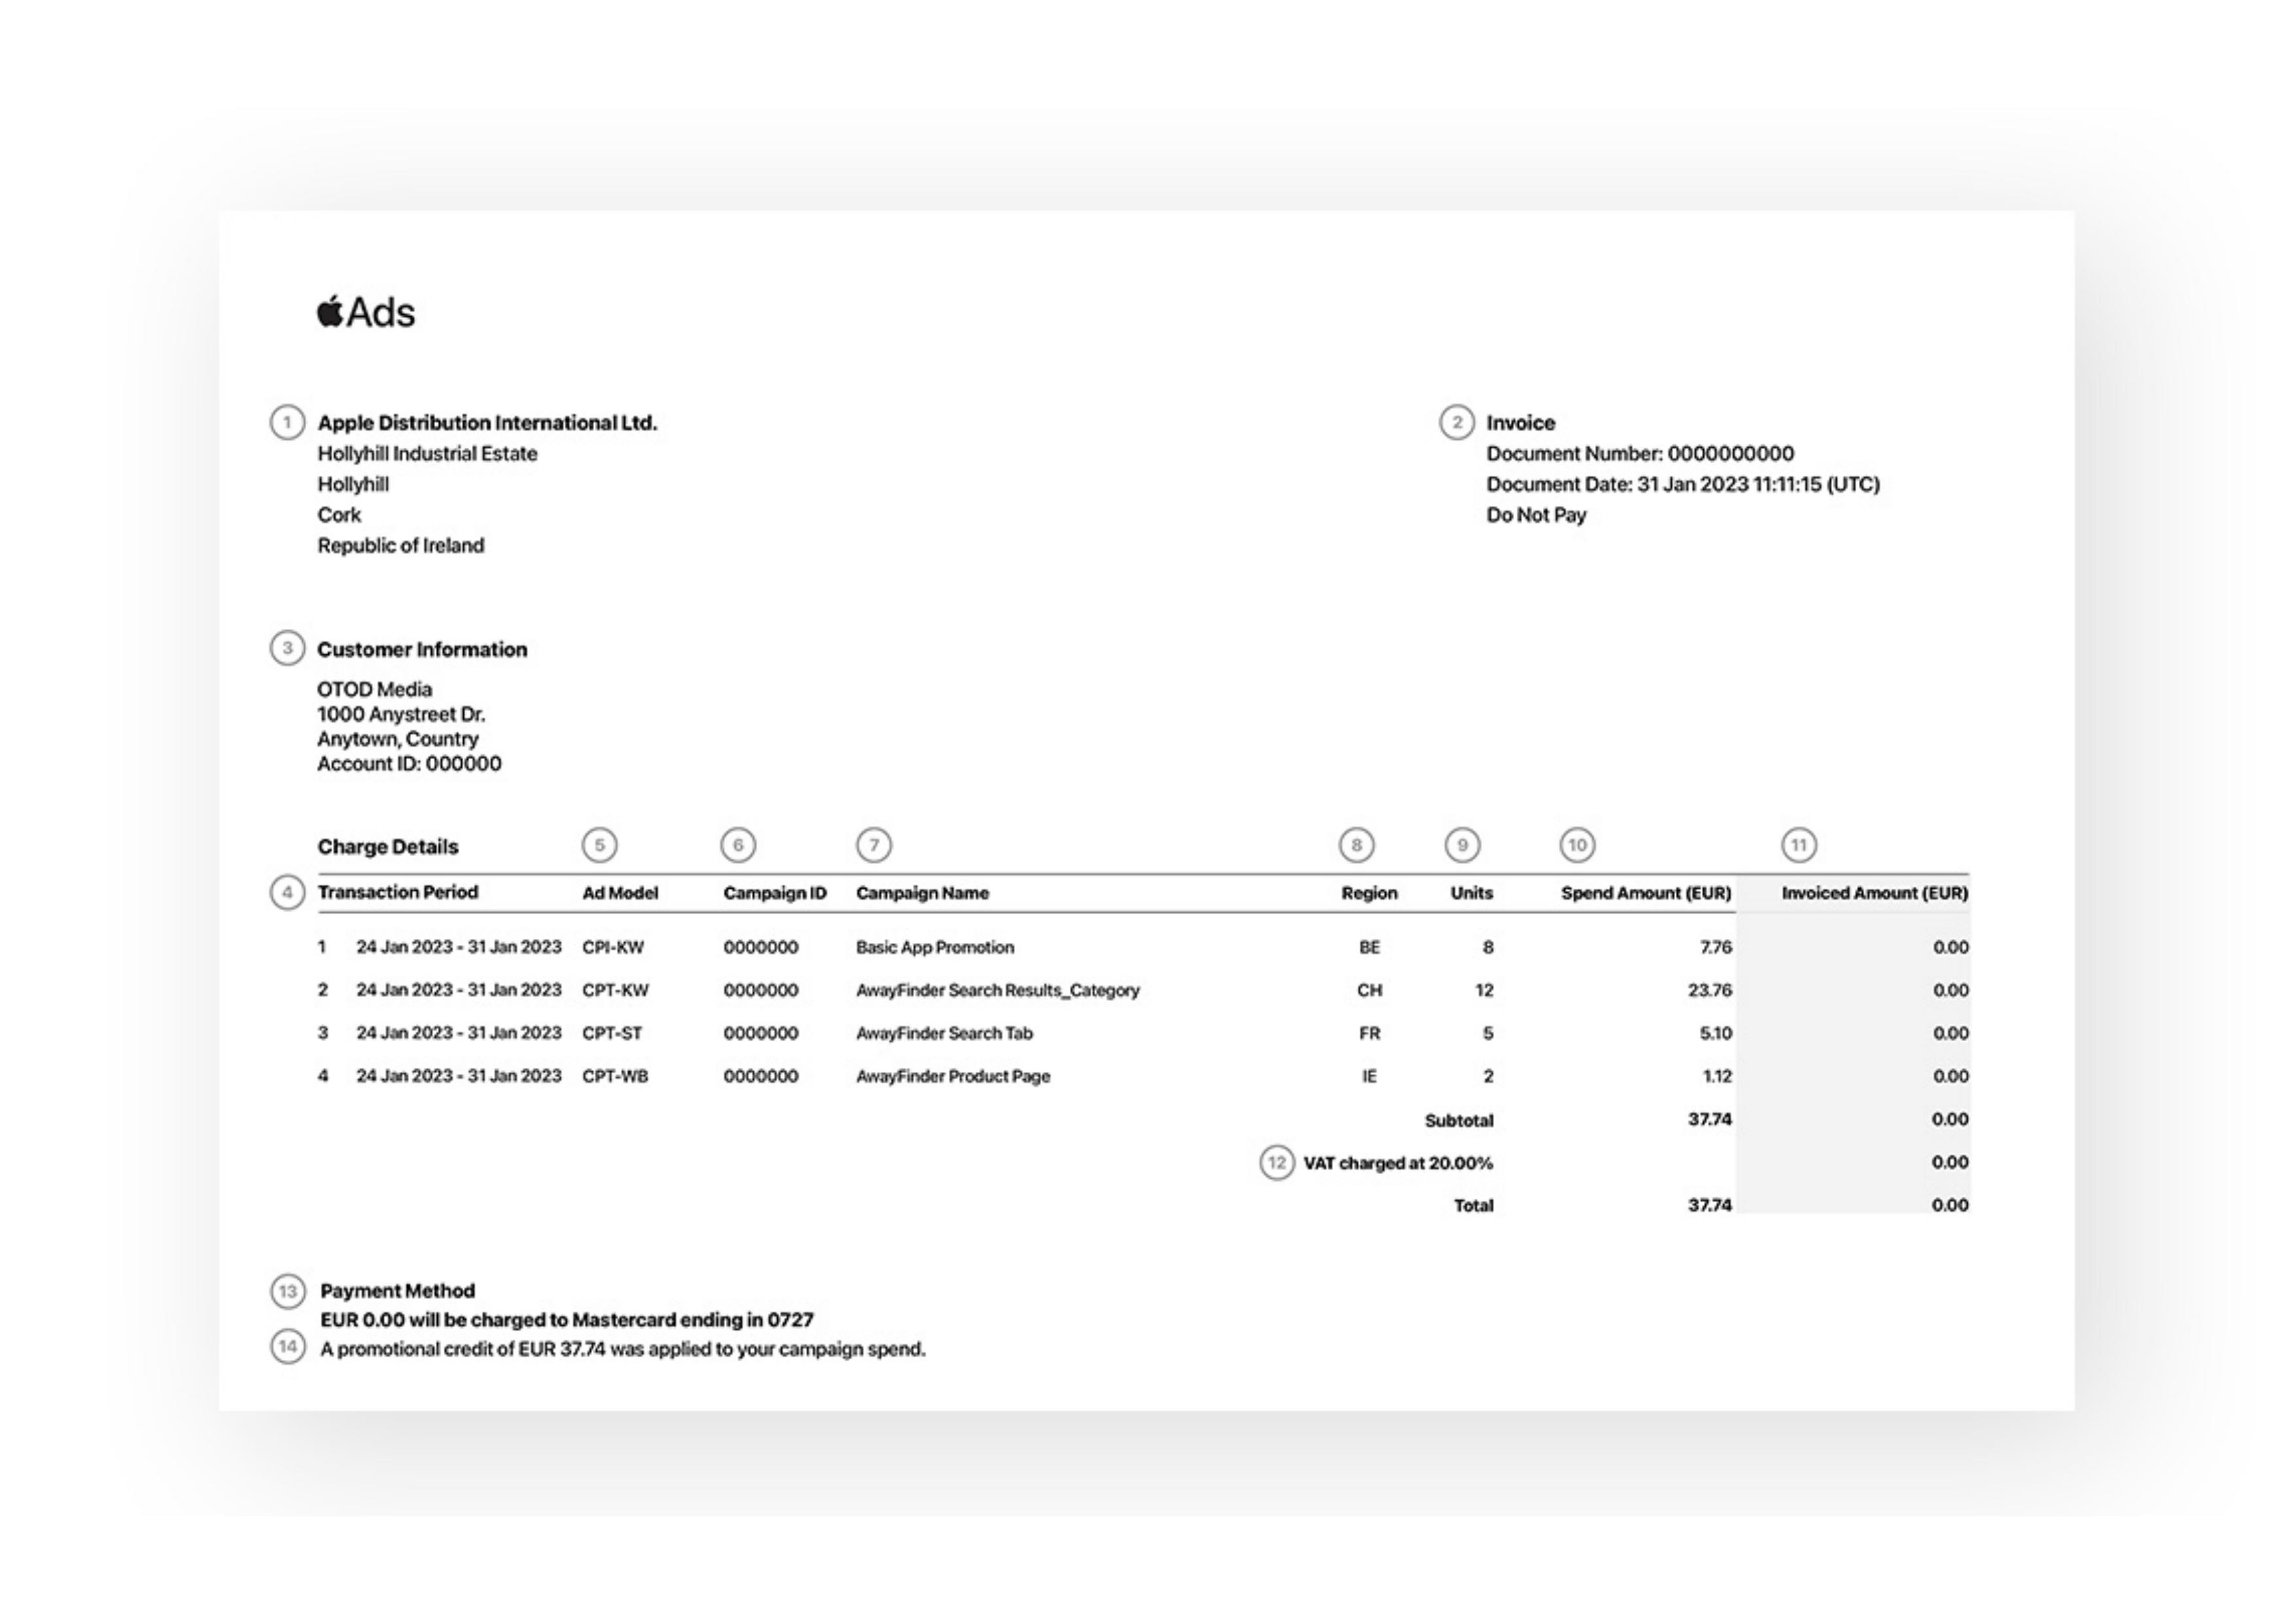

In [ ]:
## View converted image
from google.colab import files
uploaded = files.upload()


from pdf2image import convert_from_path
from PIL import Image
import os

for filename in uploaded.keys():
    print(f"📁 Uploaded file: {filename}")

    pages = convert_from_path(filename, dpi=300)
    if not pages:
        raise ValueError("PDF has no pages.")

    image = pages[0].convert("RGB")


    output_path = f"converted_{os.path.splitext(filename)[0]}.jpg"
    image.save(output_path, "JPEG")
    print(f"✅ Converted image saved as: {output_path}")

    from IPython.display import Image as ColabImage, display
    display(ColabImage(output_path))
